# 1. Multinomial Logistic Regression

Logistic regression has been used in the field of biological research since the early twentieth century. Then it began to be used in many social sciences. Logistic regression is applicable when the dependent variable (target value) is categorical.

For example, we need to predict:

- whether the email is spam (1) or not (0);
- whether the tumor is malignant (1) or benign (0).

$\boldsymbol{Multinomial}$ $\boldsymbol{logistic}$ $\boldsymbol{regression}$ is a statistical method used for classification problems where the outcome can take on more than two categories. It's an extension of binary logistic regression. The goal is to model the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables.

```{note} Let's look at the following examples:
- Classification of Texts: Determining the topic of the text (for example, sports, politics, technology, art).

- Medical Diagnosis: Classification of the type of disease (eg, infectious, inflammatory, genetic, metabolic).
```

In each of these scenarios, the outcome is multiple categories, and multinomial logistic regression can be used to predict the probability of each category.

![Alt text](https://ekababisong.org/assets/seminar_IEEE/multinomial-example.png)


##### Data Structure  
Let's imagine a data set $\mathcal D$, where each element consists of a pair of feature vectors $\boldsymbol x_i$ and a class label $y_i$:

Let $\mathcal{D}$ be a dataset defined as:

$$
\mathcal{D} = \{(\boldsymbol{x}_i, y_i)\}_{i=1}^n \quad \text{where } \boldsymbol{x}_i \in \mathbb{R}^d \text{ and } y_i \in \mathcal{Y}.
$$

Здесь $\mathcal Y$ — это множество возможных категорий.

##### Probability Prediction
Multinomial logistic regression predicts the probability of membership in each category:

The predicted probability vector $\boldsymbol{\hat{y}}$ is defined as:

$$
\boldsymbol{\hat{y}} = (p_1, \ldots, p_K), \quad \text{where } p_k > 0 \text{ and } \sum_{k=1}^K p_k = 1.
$$


##### Calculating Logits and Softmax Transformation
Logits are calculated as a linear combination of the input features and then converted to probabilities using the softmax function:

The logits $\boldsymbol{z}$ are calculated as a linear combination of the input features $\boldsymbol{x}$ and the weights $\boldsymbol{w}_k$ for each class, and the predicted probability vector $\boldsymbol{\hat{y}}$ is obtained through the softmax function:

$$
z_k = \boldsymbol{x}^\top \boldsymbol{w}_k, \quad \boldsymbol{\hat{y}} = \text{Softmax}(\boldsymbol{z}) = \left( \frac{e^{z_1}}{\sum_{k=1}^K e^{z_k}}, \ldots , \frac{e^{z_K}}{\sum_{k=1}^K e^{z_k}} \right)
$$


##### Class Selection
The predicted class is given by the argument that maximizes the probabilities:

$$
\text{Predicted class} = \arg\max_{1 \leq k \leq K} p_k
$$

##### Model parameters
The weight matrix $\boldsymbol{W}$ is defined as:

$$
\boldsymbol{W} = [\boldsymbol{w}_1 \ldots \boldsymbol{w}_K]
$$

### Quiz: Basic Concepts of Multinomial Logistic Regression


In [18]:
from jupyterquiz import display_quiz
display_quiz("#quiz_intro")

<IPython.core.display.Javascript object>

### Example: MNIST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'svg'

X, Y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

X = X.astype(float).values / 255
Y = Y.astype(int).values

##### Splitting into train and test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=10000)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [4]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 955, 1156, 1001,  987,  955,  910,  975, 1109,  967,  985]))

##### Fitting and evaluation

In [5]:
%%time
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.92
CPU times: user 7min 41s, sys: 30.7 s, total: 8min 11s
Wall time: 2min 30s


##### Confusion matrix


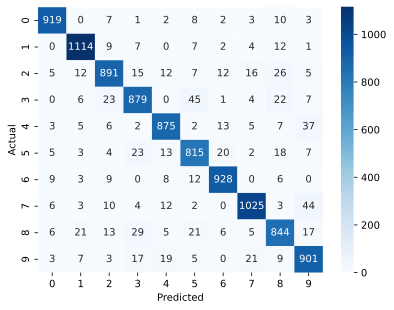

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred, model.classes_)

##### Prediction Probability Distribution for a Selected Class

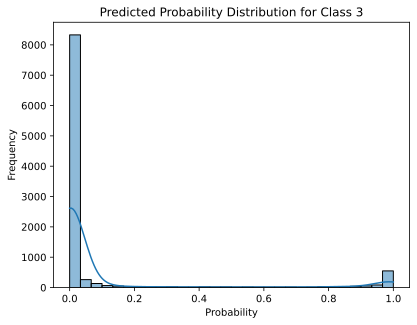

In [7]:
def plot_prediction_probabilities(model, X_test, class_idx):
    probabilities = model.predict_proba(X_test)[:, class_idx]
    sns.histplot(probabilities, kde=True, bins=30)
    plt.title(f'Predicted Probability Distribution for Class {class_idx}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_probabilities(model, X_test, class_idx=3)

##### Sample Digit Visualization

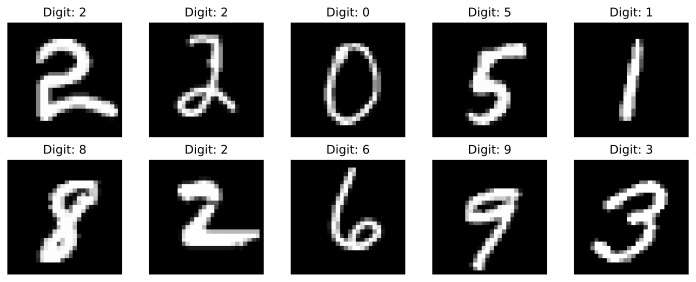

In [8]:
def plot_digits(samples, labels, n_rows=2, n_cols=5):
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Digit: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(X_test[:10], y_pred[:10])

#####  Feature Distribution Plot

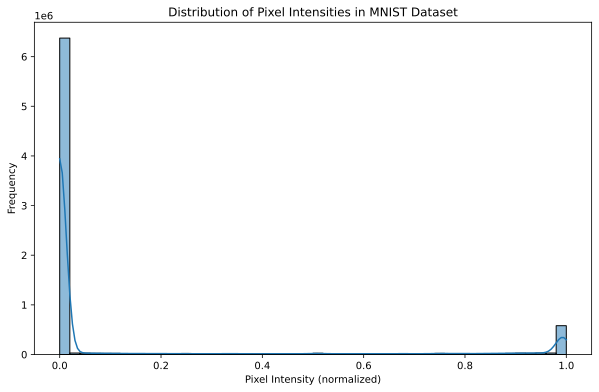

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pixel_intensity_distribution(X_test):
    # Flatten the images to get the distribution of pixel values
    pixel_values = X_test.flatten()

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(pixel_values, bins=50, kde=True)
    plt.title('Distribution of Pixel Intensities in MNIST Dataset')
    plt.xlabel('Pixel Intensity (normalized)')
    plt.ylabel('Frequency')
    plt.show()

# Call the function with the MNIST data
plot_pixel_intensity_distribution(X_test)

# 2.  Mathematical Foundations

#### Example Problem: Predicting Election Outcomes
Imagine a political analyst wants to predict the outcome of a future election based on various socioeconomic indicators. There are three political parties (A, B, and C) that voters can choose from. The analyst has collected a dataset containing previous election outcomes and corresponding indicators such as economic growth, unemployment rate, and education level.

##### Dataset Structure
The dataset $\mathcal{D}$ consists of $n$ samples with the following structure:

- Economic growth rate ($x_1$)
- Unemployment rate ($x_2$)
- Average education level ($x_3$)
- Outcome of the election (Party A, Party B, Party C)
- Each instance in the dataset is a vector $\boldsymbol{x}_i \in \mathbb{R}^3$, and the corresponding label $y_i$ is one of ${1, 2, 3}$, representing the three parties.

##### Problem Formulation
The multinomial logistic regression model can be applied to this problem to estimate the probability of each election outcome based on the socioeconomic indicators.

##### Mathematical Formulation
For a given instance $\boldsymbol{x}$, the probability that the outcome is for party $k$ is modeled as:


$$
P(y = k|\boldsymbol{x}) = \frac{\exp(\boldsymbol{x}^\top \boldsymbol{w}_k)}{\sum_{j=1}^{3} \exp(\boldsymbol{x}^\top \boldsymbol{w}_j)}
$$

Here, $\boldsymbol{w}_k$ represents the weight vector associated with party $k$, which the model will learn during training.

##### Training the Model
Using historical election data, the analyst trains a multinomial logistic regression model. The model estimates the parameters $\boldsymbol{w}_k$ for each party by maximizing the likelihood of the observed data.

##### Making Predictions
Once trained, the model can predict the probability distribution over the three parties for a new set of indicators. If a new data point has indicators $\boldsymbol{x}_{\text{new}} = [2.5%, 5%, 12 \text{ years}]$, the model will provide three probabilities corresponding to the likelihood of each party winning the election.


```{admonition} Solution
The analyst trains the model and makes predictions for a new set of indicators. The output probabilities might look something like this:

$$P(\text{Party A}|\boldsymbol{x}_{\text{new}}) = 0.70$$
$$P(\text{Party B}|\boldsymbol{x}_{\text{new}}) = 0.20$$
$$P(\text{Party C}|\boldsymbol{x}_{\text{new}}) = 0.10$$

```

#### Quiz: Mathematics-focused questions

In [19]:
from jupyterquiz import display_quiz
display_quiz("#quiz_math")

<IPython.core.display.Javascript object>

# 3. Data Preparation for Multinomial Logistic Regression


# 4. Model Building


# 5. Model Evaluation


# 6. Case Study: Real-world Application

# 7. Common Pitfalls and Best Practices


# 8. Interactive Exercises


In [ ]:
# Define the plotting function
def plot_results(X_pca, y_true, y_pred):
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('True Labels', 'Predicted Labels'))

    # Add scatter plots
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_true, size=5, colorscale='Viridis', showscale=True),
                             name='True Label'), row=1, col=1)
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                             marker=dict(color=y_pred, size=5, colorscale='Viridis', showscale=True),
                             name='Predicted Label'), row=1, col=2)

    # Update layout
    fig.update_layout(height=400, width=1200, title_text="PCA of MNIST Data")
    
    # Show figure
    fig.show()

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import ipywidgets as widgets

# Load and normalize MNIST data
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X = X / 255.0
Y = Y.astype(int)

# Subsample the data for quicker processing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, _ in sss.split(X, Y):
    X_sub, Y_sub = X[train_index], Y[train_index]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_sub)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_sub, test_size=0.2, random_state=42)

# Define the training and evaluation function
def train_and_evaluate(C, max_iter, solver):
    # Create logistic regression model
    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, multi_class='multinomial')
    # Fit the model
    model.fit(X_train, y_train)
    # Predict the classes
    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model trained with C={C}, max_iter={max_iter}, solver='{solver}'")
    print(f"Model Accuracy: {accuracy:.2f}")

    # Call the plot_results function
    plot_results(X_test, y_test, y_pred)

# Create interactive widgets for model parameters
C_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-4, max=4, step=0.1, description='C (Regularization strength):')
max_iter_slider = widgets.IntSlider(value=1000, min=100, max=2000, step=100, description='Max Iterations:')
solver_dropdown = widgets.Dropdown(options=['lbfgs', 'saga'], value='lbfgs', description='Solver:')

# Display the widgets and link to the train_and_evaluate function
interactive_plot = widgets.interactive(train_and_evaluate, C=C_slider, max_iter=max_iter_slider, solver=solver_dropdown)
display(interactive_plot)

# 9. Conclusion and Further Resources
